In [4]:
import umap
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib import colors
import yaml
from yaml.loader import SafeLoader
import json
from collections import OrderedDict

In [9]:
test = "cingulate_ACCpatterns_new_crop"
#model = "2023-04-21/16-58-19_2"
model = "comparison_HCP_full/ACC_new_crop_7" # model using crops compatible with adults and babies
dir = "/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/"+model+"/"+test+"_embeddings/"

output_dir = "/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/"+model+"/"

dir_Utrecht_dHCP = "/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/"+model+"/cingulate_Utrecht_dHCP_new_crop_embeddings/"
#dir_Utrecht = "/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/"+model+"/cingulate_Utrecht_embeddings/"
#dir_dHCP = "/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/"+model+"/cingulate_dHCP_embeddings/"

In [10]:

#print the config and AUC
with open(dir+'../partial_config.yaml') as f:
    config = yaml.load(f, Loader=SafeLoader)
    dataset_name = config['dataset_name']

with open(dir + "values.json") as f:
    AUC = json.load(f)
    AUC = AUC["cross_val_auc"]

print(f'dataset for training : {dataset_name} \ndataset for testing : ' + test + f"\nCross val AUC: ({AUC[0]},{AUC[1]})")

dataset for training : cingulate_HCP_full 
dataset for testing : cingulate_ACCpatterns_new_crop
Cross val AUC: (0.679932318104907,0.002225828272780683)


In [11]:
#load embeddings
embeddings_dir = dir + "cross_val_effective_embeddings.csv"
df_embeddings = pd.read_csv(embeddings_dir, index_col=0)

#load true labels
label_dir = dir + "cross_val_predicted_labels.csv" #NB: predicted_labels first column are actually the true labels
labels = pd.read_csv(label_dir, index_col=0)
labels.sort_index(inplace=True)
labels = labels.label.tolist()

In [12]:
#load Utrecht/dHCP
preterm_dir = dir_Utrecht_dHCP + "full_embeddings.csv"
df_preterm = pd.read_csv(preterm_dir, index_col=0)
labels_preterm = [2 for k in range(71)] + [3 for k in range(41)]

#load Utrecht
utrecht_dir1 = dir_Utrecht + "train_embeddings.csv"
utrecht_dir2 = dir_Utrecht + "val_embeddings.csv"
df_utrecht_1 = pd.read_csv(utrecht_dir1, index_col=0)
df_utrecht_2 = pd.read_csv(utrecht_dir2, index_col=0)

df_utrecht = pd.concat((df_utrecht_1,df_utrecht_2))
labels_utrecht = [2 for k in range(df_utrecht.shape[0])]

#load dHCP
dHCP_dir1 = dir_dHCP + "train_embeddings.csv"
dHCP_dir2 = dir_dHCP + "val_embeddings.csv"
df_dHCP_1 = pd.read_csv(dHCP_dir1, index_col=0)
df_dHCP_2 = pd.read_csv(dHCP_dir2, index_col=0)

df_dHCP = pd.concat((df_dHCP_1,df_dHCP_2))
labels_dHCP = [3 for k in range(df_dHCP.shape[0])]

In [13]:
#concat dHCP Utrecht and adult set (new label for Utrecht and dHCP)
df_complete = pd.concat((df_embeddings,df_preterm))
labels_complete = labels + labels_preterm

In [14]:
#fit the umap with the adult data, then apply it to all data

reducer = umap.UMAP()
embeddings = reducer.fit_transform(df_embeddings)
embeddings_preterm = reducer.transform(df_preterm)

embeddings_full = np.vstack((embeddings, embeddings_preterm))

/home/jl274628/Runs/02_deep_supervised/Program/2023_agaudin_jchavas_folding_supervised/venv/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [162]:
#fit the umap on all data
reducer = umap.UMAP()
embeddings = reducer.fit_transform(df_complete)

In [17]:
#fit the UMAP on baby data only, and plot only babies
labels_complete = labels_preterm

reducer = umap.UMAP()
#embeddings_full = reducer.fit_transform(df_babies)
reducer.fit(df_preterm)
embeddings_full = reducer.transform(df_preterm)

In [121]:
#fit the UMAP on baby data only, and plot all
df_complete = pd.concat((df_embeddings,df_preterm))
labels_complete = labels + labels_preterm

reducer = umap.UMAP()
embeddings_babies = reducer.fit(df_preterm)
embeddings_full = reducer.transform(df_complete)

In [114]:
#choose a parameter to show on umap (transparence): gestational age etc...
age_dir = "/home/jl274628/Runs/data/gestational_age.csv"
age_df = pd.read_csv(age_dir,sep=',')
#nb: order: utrecht, dhcp
age_list = age_df['GA'].tolist()
#there may be Nan values, just replace with 40 weeks...
for k,elem in enumerate(age_list):
    if math.isnan(elem):
        age_list[k]=40.0

alpha_list = age_list.copy()
alpha_list = [(elem - min(age_list))/32 for elem in age_list] #let's focus on the 26-32weeks
alpha_list = [1/3 + 2/3*elem for elem in alpha_list]


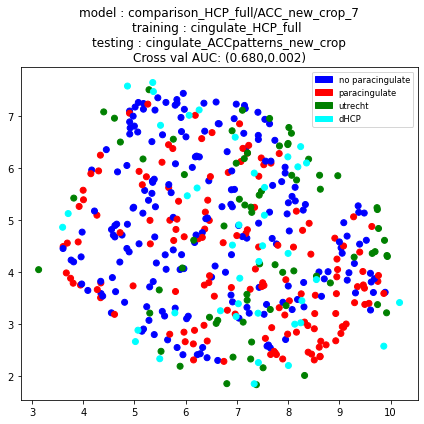

In [16]:
#plot UMAP

plt.close()
fig, ax = plt.subplots(figsize=(6,6))

cmap = OrderedDict({'blue': 'no paracingulate',
                    'red': 'paracingulate',
                    'green': 'utrecht',
                    'cyan': 'dHCP'
                    })

#colors
cols = [list(cmap.items())[i][0] for i in labels_complete]

#rgba colors
#NB: playing on transparency is not very visual: play on the hue ?
#colors_rgba = [colors.to_rgba(c) for c in cols]
#colors_rgba = [(r,g,b,a) for (r,g,b,_),a in zip(colors_rgba,alpha_list)]



#create manual legend
legend=[]
for col,lab in cmap.items():
    col_patch = mpatches.Patch(color=col, label=lab)
    legend.append(col_patch)

#plot
ax.scatter(embeddings_full[:, 0],
            embeddings_full[:, 1],
            c=cols)

ax.legend(handles=legend, fontsize='small')
plt.title(f'model : {model}\ntraining : {dataset_name} \ntesting : ' + test + f"\nCross val AUC: ({AUC[0]:.3f},{AUC[1]:.3f})")
fig.tight_layout()

plt.savefig(output_dir+'umap_dHCP_Utrecht_fit_baby_apply_baby.png',facecolor='white')
plt.show()